### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
month, alive = np.loadtxt('data/retention-example.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
month = month.astype(int)
alive = alive.astype(float)

### Non-linear Least Square - 1 Segment

In [ ]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [12]:
from scipy.optimize import minimize

def square_error(x):
    e_retention = np.ones_like(retention) * (x**month) # Expected monthly retention rate
    e_churn = e_retention[:-1] - e_retention[1:] # Expected monthly churn rate
    en_loss = e_churn * alive[0] # Expected number of losses / month
    loss_error = np.sum((en_loss - loss)**2) # Sum of square of error - expected and actual loss
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2 # Sum of square of error - expected and actual survivors at the end of the period
    return loss_error + survivor_error

x_guess = 0.94
retention_rate = minimize(square_error, x_guess).x
print('Predicted Monthly Retention Rate =', retention_rate[0])

Predicted Monthly Retention Rate = 0.948429474874902


(0.0, 1.5)

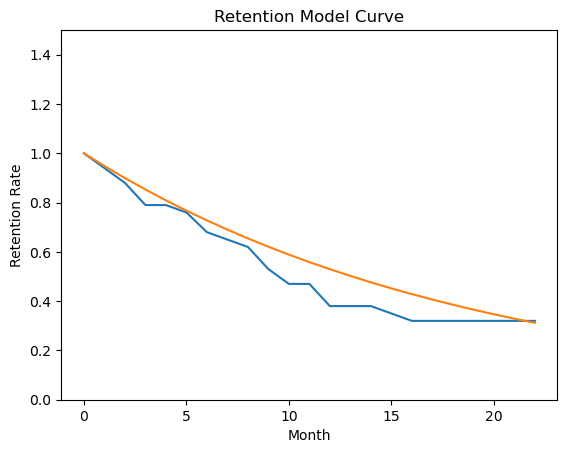

In [ ]:
plt.plot(month, retention, label="Actual")
plt.plot(month, np.ones_like(retention) * (retention_rate**month), label="Expected")
plt.title('Retention Model Curve - 1 Segment')
plt.xlabel("Month")
plt.ylabel("Retention Rate")
plt.ylim((0,1.5))